<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import gym
import matplotlib.pyplot as plt

In [11]:
env = gym.make("CartPole-v1")
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Policy Gradients

In [12]:
model_pg = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(n_outputs, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PLaying One Step

In [13]:
def play_one_step(env, obs, model):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        action = tf.random.categorical(tf.math.log(probas), num_samples=1)
        loss = tf.reduce_mean(keras.losses.sparse_categorical_crossentropy(action, probas))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

Playing Multiple Episode

In [14]:
def play_multiple_episodes(env, n_episodes, model):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(env._max_episode_steps):
            obs, reward, done, grads = play_one_step(env, obs, model)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Counting Discount Reward

In [15]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted - reward_mean) / reward_std
            for discounted in all_discounted_rewards]

Iteration

In [16]:
n_iterations = 100
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=0.01)

Training Policy Gradients

In [18]:
mean_rewards_pg = []

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, model_pg)
    mean_rewards_pg.append(np.mean([sum(rewards) for rewards in all_rewards]))
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    all_mean_grads = []
    for var_index in range(len(model_pg.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model_pg.trainable_variables))
    print(f"\rIterasi PG: {iteration + 1}/{n_iterations}, Rata-rata Reward: {mean_rewards_pg[-1]:.1f}", end="")

Iterasi PG: 100/100, Rata-rata Reward: 154.9

Evaluate

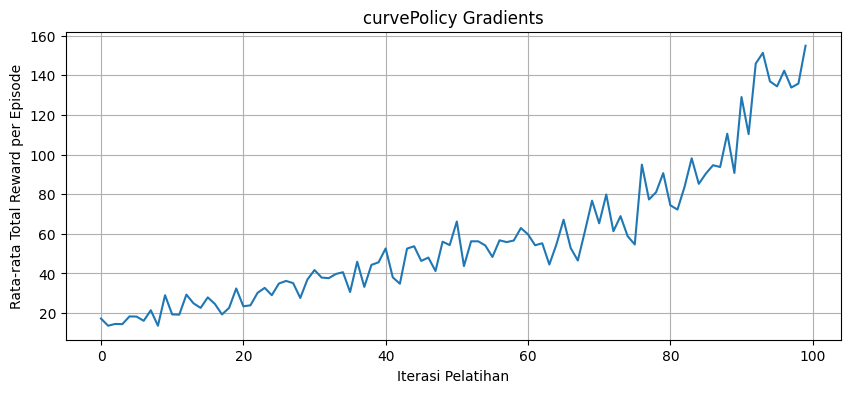

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(mean_rewards_pg)
plt.title("curvePolicy Gradients")
plt.xlabel("Iterasi Pelatihan")
plt.ylabel("Rata-rata Total Reward per Episode")
plt.grid(True)
plt.show()

Visualizing Policy Gradient agent

In [20]:
obs = env.reset()
for step in range(n_max_steps):
    probas = model_pg(obs[np.newaxis])
    action = np.argmax(probas) # Pilih aksi terbaik, bukan acak
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        print("Selesai setelah {} langkah".format(step+1))
        break
env.close()
print("-" * 50)

/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


--------------------------------------------------


Deep Q-Network

Q-Network Model

In [21]:
input_shape = [n_inputs]
model_dqn = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [22]:
from collections import deque
replay_memory = deque(maxlen=2000)


Epsilon-Greedy Policy


In [23]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model_dqn.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones


Playing One Step


In [24]:
def play_one_step_dqn(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done


Training Deep Q-Networks


In [25]:
batch_size = 32
discount_factor = 0.95
optimizer_dqn = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.MeanSquaredError()

In [26]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_dqn.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)

    with tf.GradientTape() as tape:
        mask = tf.one_hot(actions, n_outputs)
        all_Q_values = model_dqn(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model_dqn.trainable_variables)
    optimizer_dqn.apply_gradients(zip(grads, model_dqn.trainable_variables))

Iteration

In [27]:
all_rewards_dqn = []
for episode in range(300):
    obs = env.reset()
    episode_reward = 0
    for step in range(n_max_steps):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done = play_one_step_dqn(env, obs, epsilon)
        episode_reward += reward
        if done:
            break
    all_rewards_dqn.append(episode_reward)

    if episode > 50:
        training_step(batch_size)

    if (episode + 1) % 10 == 0:
        print(f"Episode DQN: {episode + 1}/300, Reward: {episode_reward:.1f}, Epsilon: {epsilon:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Episode DQN: 10/300, Reward: 25.0, Epsilon: 0.982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Episode DQN: 20/300, Reward: 17.0, Epsilon: 0.962
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Evaluate

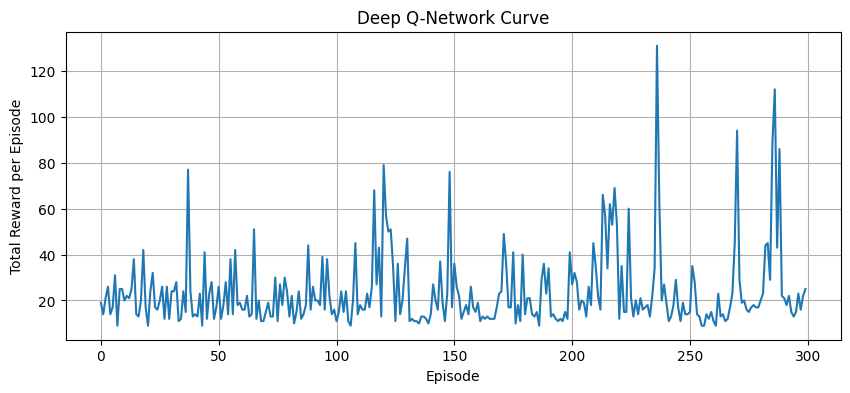

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(all_rewards_dqn)
plt.title("Deep Q-Network Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.grid(True)
plt.show()

Visulaizing Deep Q-Networks Agent

In [29]:
obs = env.reset()
for step in range(n_max_steps):
    action = epsilon_greedy_policy(obs) # Epsilon default = 0
    obs, reward, done, info = env.step(action)
    if done:
        print("Selesai setelah {} langkah".format(step+1))
        break
env.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━